# CPSC 340 Assignment 6

In [114]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

def classification_error(y, yhat):
    return np.mean(y!=yhat)

## Instructions
rubric={mechanics:5}


The above points are allocated for following the [homework submission instructions](https://github.ugrad.cs.ubc.ca/CPSC340-2017W-T2/home/blob/master/homework_instructions.md).

## Exercise 1: Finding similar items

For this question we'll be using the [Amazon product data set](http://jmcauley.ucsd.edu/data/amazon/). The author of the data set has asked for the following citations:

> Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering.
> R. He, J. McAuley.
> WWW, 2016.
> 
> Image-based recommendations on styles and substitutes.
> J. McAuley, C. Targett, J. Shi, A. van den Hengel.
> SIGIR, 2015.

We will focus on the "Patio, Lawn, and Garden" section. Download the [ratings](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Patio_Lawn_and_Garden.csv) and place the file in the `data` directory with the original filename. Once you do that, the code below should load the data:

In [120]:
filename = "ratings_Patio_Lawn_and_Garden.csv"

with open(os.path.join("..", "data", filename), "rb") as f:
    ratings = pd.read_csv(f,names=("user","item","rating","timestamp"))
ratings.head()

,user,item,rating,timestamp
0,A2VNYWOPJ13AFP,0981850006,5.0,1259798400
1,A20DWVV8HML3AW,0981850006,5.0,1371081600
2,A3RVP3YBYYOPRH,0981850006,5.0,1257984000
3,A28XY55TP3Q90O,0981850006,5.0,1314144000
4,A3VZW1BGUQO0V3,0981850006,5.0,1308268800


We'd also like to construct the user-product matrix `X`. Let's see how big it would be:

In [121]:
def get_stats(ratings, item_key="item", user_key="user"):
    print("Number of ratings:", len(ratings))
    print("The average rating:", np.mean(ratings["rating"]))

    d = len(set(ratings[item_key]))
    n = len(set(ratings[user_key]))
    print("Number of users:", n)
    print("Number of items:", d)
    print("Fraction nonzero:", len(ratings)/(n*d))
    print("Size of full X matrix: %.2f GB" % ((n*d)*8/1e9))

    return n,d

n,d = get_stats(ratings)

Number of ratings: 993490
The average rating: 4.006400668350965
Number of users: 714791
Number of items: 105984
Fraction nonzero: 1.3114269915944552e-05
Size of full X matrix: 606.05 GB


600 GB! That is way too big. We don't want to create that matrix. On the other hand, we see that we only have about 1 million ratings, which would be around 8 MB ($10^6$ numbers $\times$ at 8 bytes per double precision floating point number). Much more manageable. 

In [122]:
def create_X(ratings,n,d,user_key="user",item_key="item"):
    user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(n))))
    item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(d))))

    user_inverse_mapper = dict(zip(list(range(n)), np.unique(ratings[user_key])))
    item_inverse_mapper = dict(zip(list(range(d)), np.unique(ratings[item_key])))

    user_ind = [user_mapper[i] for i in ratings[user_key]]
    item_ind = [item_mapper[i] for i in ratings[item_key]]

    X = sparse_matrix((ratings["rating"], (user_ind, item_ind)), shape=(n,d))
    
    return X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind

X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(ratings, n, d)

In [8]:
# sanity check
print(X.shape) # should be number of users by number of items
print(X.nnz)   # number of nonzero elements -- should equal number of ratings

(714791, 105984)
993490


In [9]:
X.data.nbytes

7947920

(Above: verifying our estimate of 8 MB to store sparse `X`)

### 1.1
rubric={reasoning:2}

Find the following items:

1. the item with the most reviews
2. the item with the most total stars
3. the item with the highest average stars

Then, find the names of these items by looking them up with the url https://www.amazon.com/dp/ITEM_ID, where `ITEM_ID` is the id of the item.

In [11]:
url_amazon = "https://www.amazon.com/dp/%s"

# example:
print(url_amazon % 'B00CFM0P7Y')

https://www.amazon.com/dp/B00CFM0P7Y


In [12]:
url_amazon = "https://www.amazon.com/dp/%s"
# 1. the item with the most reviews

most_reviewed = item_inverse_mapper[(X!=0.).sum(0).argmax()]
print(url_amazon % most_reviewed)

# 2. the item with the most total stars

most_total_stars = item_inverse_mapper[X.sum(axis=0).argmax()]
print(url_amazon % most_total_stars)

# 3. the item with the highest average stars

highest_average_stars = item_inverse_mapper[(X.sum(axis=0)/(X != 0.).sum(0)).argmax()]
print(url_amazon % highest_average_stars)

https://www.amazon.com/dp/B000HCLLMM
https://www.amazon.com/dp/B000HCLLMM
https://www.amazon.com/dp/0981850006


### 1.2
rubric={reasoning:2}

Make the following histograms 

1. The number of ratings per user
2. The number of ratings per item
3. The ratings themselves

For the first two, use
```
plt.yscale('log', nonposy='clip')
``` 
to put the histograms on a log-scale.

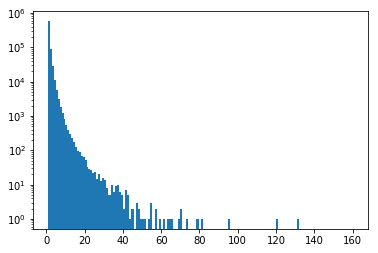

In [19]:
# 1. The number of ratings per user
x = (X != 0.).sum(axis=1).flatten()
a = np.squeeze(np.asarray(x))

plt.hist(a, range(a.min(), a.max()))
plt.yscale('log', nonposy='clip')


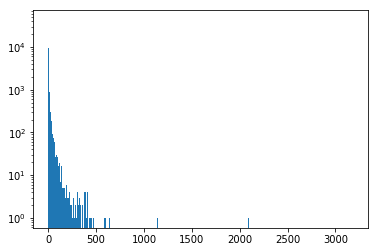

In [20]:
# 2. The number of ratings per item

x2 = (X != 0.).sum(axis=0).flatten()
a2 = np.squeeze(np.asarray(x2))
plt.hist(a2, range(a2.min(), a2.max()))
plt.yscale('log', nonposy='clip')

(array([ 119633.,   57487.,   80891.,  735479.]),
 array([1, 2, 3, 4, 5]),
 <a list of 4 Patch objects>)

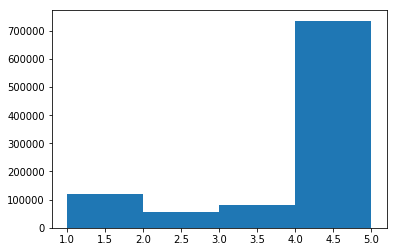

In [21]:
# 3. The ratings themselves

x3 = X[X != 0].flatten().astype(int)
a3 = np.squeeze(np.asarray(x3))
plt.hist(a3, bins=[1, 2, 3, 4, 5])

### 1.3
rubric={reasoning:1}

Use scikit-learn's [NearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object (which uses Euclidean distance by default) to find the 5 items most similar to [Brass Grill Brush 18 Inch Heavy Duty and Extra Strong, Solid Oak Handle](https://www.amazon.com/dp/B00CFM0P7Y). 

The code block below grabs the row of `X` associated with the grill brush. The mappers take care of going back and forther between the IDs (like `B00CFM0P7Y`) and the indices of the sparse array (0,1,2,...).

Note: keep in mind that `NearestNeighbors` is for taking neighbors across rows, but here we're working across columns.

In [22]:
grill_brush = "B00CFM0P7Y"
grill_brush_ind = item_mapper[grill_brush]
grill_brush_vec = X[:,grill_brush_ind]

print(url_amazon % grill_brush)

https://www.amazon.com/dp/B00CFM0P7Y


In [39]:
model1 = NearestNeighbors()
model1.fit(X.T)
closest_items1 = np.squeeze(model1.kneighbors(grill_brush_vec.T,6, return_distance=False))
for i in closest_items1[1:6]:
    print(url_amazon % item_inverse_mapper[i])

https://www.amazon.com/dp/B00IJB5MCS
https://www.amazon.com/dp/B00IJB4MLA
https://www.amazon.com/dp/B00EXE4O42
https://www.amazon.com/dp/B00743MZCM
https://www.amazon.com/dp/B00HVXQY9A


### 1.4
rubric={reasoning:1}

Using cosine similarity instead of Euclidean distance in `NearestNeighbors`, find the 5 products most similar to `B00CFM0P7Y`.

In [40]:
model2 = NearestNeighbors(metric='cosine')
model2.fit(X.T)
closest_items2 = np.squeeze(model2.kneighbors(grill_brush_vec.T,6, return_distance=False))
for i in closest_items2[1:6]:
    print(url_amazon % item_inverse_mapper[i])

https://www.amazon.com/dp/B00IJB5MCS
https://www.amazon.com/dp/B00IJB8F3G
https://www.amazon.com/dp/B00IJB4MLA
https://www.amazon.com/dp/B00EF45AHU
https://www.amazon.com/dp/B00EF3YF0Y


### 1.5
rubric={reasoning:2}

For each of the two metrics, compute the compute the total popularity (total stars) of each of the 5 items and report it. Do the results make sense given what we discussed in class about Euclidean distance vs. cosine similarity? 


In [37]:
print("The total ratings for each of the 5 closest items using euclidean dist")
for i in closest_items1:
    print(X[:,i].sum())

print("The total ratings for each of the 5 closest items using cosine similarity")
for j in closest_items2:
    print(X[:,j].sum())

The total ratings for each of the 5 closest items using euclidean dist
1244.0
266.0
205.0
5.0
5.0
The total ratings for each of the 5 closest items using cosine similarity
1244.0
266.0
438.0
205.0
311.0


This makes sense since cosine similarity chooses the most popular items (we can see that the items chosen by cosine similarity have much larger total star ratings ie are more popular)

### 1.6
rubric={reasoning:3}

PCA gives us an approximation $X \approx ZW$ where the rows of $Z$ contain a length-$k$ latent feature vectors for each user and the columns of $W$ contain a length-$k$ latent feature vectors for each item.

Another strategy for finding similar items is to run PCA and then search for nearest neighbours with Euclidean distance in the latent feature space, which is hopefully more meaningful than the original "user rating space". In other words, we run nearest neighbors on the columns of $W$. Using $k=10$ and scikit-learn's [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to perform the dimensionality reduction, find the 5 nearest neighbours to the grill brush using this method. You can access $W$ via the `components_` field of the `TruncatedSVD` object, after you fit it to the data. 

Briefly comment on your results.

Implementation note: when you call on `NearestNeighbors.kneighbors`, it expects the input to be a 2D array. There's some weirdness here because `X` is a scipy sparse matrix but your `W` will be a dense matrix, and they behave differently in subtle ways. If you get an error like "Expected 2D array, got 1D array instead" then this is your problem: a column of `W` is technically a 1D array but a column of `X` has dimension $1\times n$, which is technically a 2D array. You can take a 1D numpy array and add an extra first dimension to it with `array[None]`.

Conceptual note 1: We are using the "truncated" rather than full SVD since a full SVD would involve dense $d\times d$ matrices, which we've already established are too big to deal with. And then we'd only use the first $k$ rows of it anyway. So a full SVD would be both impossible and pointless.

Conceptual note 2: as discussed in class, there is a problem here, which is that we're not ignoring the missing entries. You could get around this by optimizing the PCA objective with gradient descent, say using `findMin` from previous assignments. But we're just going to ignore that for now, as the assignment seems long enough as it is (or at least it's hard for me to judge how long it will take because it's new).

In [126]:
svd = TruncatedSVD(n_components =10)
svd.fit(X)
W = svd.components_ 
print("variance explained %.3f" %svd.explained_variance_ratio_.sum())
model = NearestNeighbors()
model.fit(W.T)

grill_vec_new = W[:,grill_brush_ind]

closest_items3 = np.squeeze(model.kneighbors(grill_vec_new.T[None],6, return_distance=False))

for i in closest_items3[1:6]:
    print(url_amazon % item_inverse_mapper[i])



variance explained 0.020
https://www.amazon.com/dp/B000X9BNG8
https://www.amazon.com/dp/B000MVLB8W
https://www.amazon.com/dp/B001VNC3Q4
https://www.amazon.com/dp/B000H1SJ8C
https://www.amazon.com/dp/B001H1NG1Q


The nearest neighbours found after using PCA with 10 components seem to not match the grill brush very well (we are getting barbeques and such). I think this has to do with the fact that we have reduced the dimensional space to be too small from the original (from 714791 to 10), so not much of the variance of the data is retained. By looking at the variance explained this would seem to be the case (only 2% of the variance explained).

## Exercise 2: putting it all together in a CPSC 340 "mini-project"
rubric={reasoning:25}

In this open-ended mini-project, you'll explore the [UCI default of credit card clients data set](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). There are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default payment next month" in the data. The rest of the columns can be used as features. 



**Your tasks:**

1. Download the data set and load it in. Since the data comes as an MS Excel file, I suggest using [`pandas.read_excel`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_excel.html) to read it in. See [Lecture 2](https://github.ugrad.cs.ubc.ca/CPSC340-2017W-T2/home/blob/master/lectures/L2.ipynb) for an example of using pandas.
2. Perform exploratory data analysis on the data set. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Randomly split the data into train, validation, test sets. The validation set will be used for your experiments. The test set should be saved until the end, to make sure you didn't overfit on the validation set. You are welcome to use scikit-learn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which takes care of both shuffling and splitting. 
4. Try scikit-learn's [DummyClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) as a baseline model.
5. Try logistic regression as a first real attempt. Make a plot of train/validation error vs. regularization strength. What’s the lowest validation error you can get?
6. Explore the features, which are described on the UCI site. Explore preprocessing the features, in terms of transforming non-numerical variables, feature scaling, change of basis, etc. Did this improve your results?
7. Try 3 other models aside from logistic regression, at least one of which is a neural network. Can you beat logistic regression? (For the neural net(s), the simplest choice would probably be to use scikit-learn's [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), but you are welcome to use any software you wish. )
8. Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. I won't make it a strict requirement, but I recommend checking out one of the following (the first two are simple scikit-learn tools, the latter two are much more sophisticated algorithms and require installing new packages): 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [hyperopt-sklearn](https://github.com/hyperopt/hyperopt-sklearn)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)
9. Explore feature selection for this problem. What are some particularly relevant and irrelevant features? Can you improve on your original logistic regression model if you first remove some irrelevant features?
10. Take your best model overall. Train it on the combined train/validation set and run it on the test set once. Does the test error agree fairly well with the validation error from before? Do you think you’ve had issues with optimization bias? Report your final test error directly in your README.md file as well as in your report.

**Submission format:**
Your submission should take the form of a "report" that includes both code and an explanation of what you've done. You don't have to include everything you ever tried - it's fine just to have your final code - but it should be reproducible. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code.

**Assessment:**
We plan to grade and fairly leniently. We don't have some secret target accuracy that you need to achieve to get a good grade. You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results. For example, if you write something like, "And then I noticed the model was overfitting, so I decided to stop using regularization" - then, well, that's not good. If you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

**And...**
This style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-6 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, don't do it out of perfectionism... do it because you're learning and enjoying it.



In [97]:
## 1. Read in the data 
credit_data = pd.read_excel('C:\\Users\\Nancy Wu\\CPSC 340 Assignments\\t4l0b_a6\\data\\default_of_credit_card_clients.xls', header=1)

X = credit_data.iloc[:,1:24]
X = X.as_matrix()

y = credit_data.iloc[:,[-1]]
y = y.as_matrix()

## 2. Summary Statistics
subset = credit_data.iloc[:,[1,2,3,4,5]]
subset.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500
std,129747.661567,0.489129,0.790349,0.521970,9.217904
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000


In the above summary statistics, we can see the distribution of the limit balance, education and age. We can also see from the marriage category that there exist values (0 and 6) such that they are not described by the dataset description.

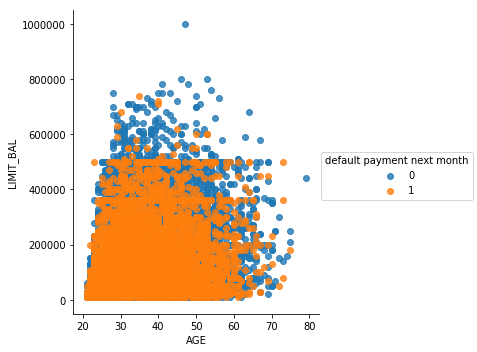

In [75]:
# 2. Plot #1
sns.lmplot(x="AGE", y="LIMIT_BAL", data=credit_data, fit_reg=False, hue='default payment next month', legend='default payment next month')

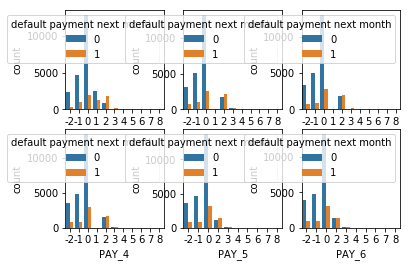

In [62]:
#2. Plot #2

fig, axs = plt.subplots(2,3)
sns.countplot(x="PAY_0",data=credit_data, hue="default payment next month", ax=axs[0,0])
sns.countplot(x="PAY_2",data=credit_data, hue="default payment next month", ax=axs[0,1])
sns.countplot(x="PAY_3",data=credit_data, hue="default payment next month", ax=axs[0,2])
sns.countplot(x="PAY_4",data=credit_data, hue="default payment next month", ax=axs[1,0])
sns.countplot(x="PAY_5",data=credit_data, hue="default payment next month", ax=axs[1,1])
sns.countplot(x="PAY_6",data=credit_data, hue="default payment next month", ax=axs[1,2])

In the first plot, I have plotted the Balance Limit vs age for both groups. It looks like people with a larger limit balance tend to not pay in the next month (blue), whereas age doesn't look like as much of a contributing factor (on it's own at least) to whether someone pays their bill the next month. We can see both color of points spread evenly across the X-axis.

In the second plot, I plotted the counts of the repayment status for each of the 6 months. We can see in each pay period, that the counts of -2, -1, 0 look similar. By similar I mean the percentages for each group (0 or 1) are distributed in a similar way when the repayment status = 0, -1, and -2, and we only see some variation between the groups when the repayment status is greater than 0. Also it is important to note that repayment status -2 and 0 were not described in the dataset description, so I' not sure what they mean. 

In [98]:
#3.  shuffle the data and split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, random_state=1)

y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)


In [99]:
#4. Dummy classifier, just predicts the most frequent observation
baseline = DummyClassifier(strategy = 'most_frequent',random_state=1)
baseline.fit(X_train,y_train)
yhat = baseline.predict(X_val)
print("classification error: %.4f" %classification_error(y_val, yhat))


classification error: 0.2202


In [100]:
#5. Logistic regression with L1 regularization
log_l1 = LogisticRegression(penalty='l1')
log_l1.fit(X_train,y_train)
log_l1_yhat = log_l1.predict(X_val)
print("classification error: %.4f" %classification_error(y_val, log_l1_yhat))

classification error: 0.1910


Text(0.5,1,'Validation error vs C in Logistic Model with L1 Regularization')

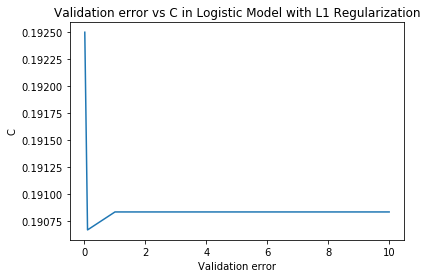

In [77]:
#5. Plot the Validation error vs 'C'

#try different regularization strengths
regularization = np.array([0.01,0.1,1,10])

valid_score = []

for i in regularization:
    log_l1 = LogisticRegression(penalty='l1', C=i)
    log_l1.fit(X_train,y_train)
    log_l1_yhat = log_l1.predict(X_val)
    valid_score.append(classification_error(y_val, log_l1_yhat))
    
plt.plot(regularization,valid_score)
plt.xlabel('Validation error')
plt.ylabel('C')
plt.title('Validation error vs C in Logistic Model with L1 Regularization')

Validation error is only slightly (about 0.0001) better when C = 0.1, than when C=1, so stick with C=1. (default)

In [101]:
#6. Preprocess features

# Regroup the data in Pay0,Pay1,etc
for i in range(5,11):
    X_train[:,i][X_train[:,i] < 0]=0
    X_val[:,i][X_val[:,i] < 0]=0

# check logistic model after regrouping
log_l1 = LogisticRegression(penalty='l1')
log_l1.fit(X_train,y_train)
log_l1_yhat = log_l1.predict(X_val)
print("classification error: %.4f" %classification_error(y_val, log_l1_yhat))

classification error: 0.1815


In [107]:
#6.  Preprocess features

# Categorize the marriage levels into dummy variables
lb = preprocessing.LabelBinarizer()
lb.fit(X_train[:,3])

dummies = lb.transform(X_train[:,3])
X_dummies = np.delete(X_train,3,1)
X_dummies = np.concatenate((X_dummies,dummies), axis=1)

val_dummies = lb.transform(X_val[:,3])
X_val_dummies = np.delete(X_val,3,1)
X_val_dummies = np.concatenate((X_val_dummies,val_dummies), axis=1)

# Check logistic model after categorization into dummies
log_l1_dummies = LogisticRegression(penalty='l1')
log_l1_dummies.fit(X_dummies,y_train)
log_l1_yhat = log_l1_dummies.predict(X_val_dummies)
print("classification error: %.4f" %classification_error(y_val, log_l1_yhat))


classification error: 0.1813


From the plots made in 2, it looked like when the repayment status was 0, -1, -2 it was hard to differentiate whether the outcome would be 0 or 1 since the proportions were similar. That is why I decided to regroup them and make 0, -1, and -2 into one group (0). 
For the marriage feature, I recoded as a dummy variable since the levels of marriage don't make sense. In other words when married=1, and single=2, and other=3, there is no significance to 2 (single) being greater than 1 (marriage). That is why I made dummy variables using the LabelBinarizer where 0,1,0,0 means single, 0,0,1,0 means married, 0,0,0,1 means other. (There was an extra category in married that was not described in the dataset description, but removing or regrouping it caused the classification to become worse so I thought there may be some significance to it even though I dont know what it is...)

In [109]:
#7. Try different models. 
# SVM : SVC with rbf kernal and C=1

svm_model = svm.SVC()
svm_model.fit(X_train,y_train)
svm_yhat=svm_model.predict(X_val)
print("classification error: %.4f" %classification_error(y_val, svm_yhat))


classification error: 0.2197


SVM with rbf kernal only managed to do slightly better than the dummy model (classification error of 0.2202), and this was incredibly slow to run compared to the other models, so I abandoned this model pretty quickly.

In [110]:
#7. Try different models
# Neural Networks

nn_model = MLPClassifier(hidden_layer_sizes=(100,),activation='logistic')
nn_model.fit(X_dummies,y_train)
1-nn_model.score(X_val_dummies,y_val)

# error: 0.2202

# optimize the hidden_layer_sizes

parameters = {'hidden_layer_sizes':[(100,),(100,10),(100,50),(100,100)]}
nn = MLPClassifier()
search = GridSearchCV(nn,parameters)
search.fit(X_dummies,y_train)

search.best_estimator_
#(100,)

nn_opt_yhat = search.predict(X_val_dummies)
print("classification error: %.4f" %classification_error(y_val,nn_opt_yhat))

classification error: 0.2358


For neural networks with the default parameters, I was able to obtain the same classification error as the dummy (0.2202). I tried optimizing over different hidden layer and number of neurons sets using gridCV, but usually the best outcome was just using the default parameters.

In [111]:
#7. Try different models
# Random Forest 

# try random forest , n_estimators (number of trees) = 10, max_depth = 10
rf_model = RandomForestClassifier(n_estimators = 10, max_depth = 10)
rf_model.fit(X_dummies,y_train)
rf_yhat = rf_model.predict(X_val_dummies)
classification_error(y_val,rf_yhat)

# error = 0.1823

# optimize the hyperparameters for random forest, this doesn't make much sense
# since the errors will change because of random bootstrap samples.

parameters = {'n_estimators':[40], 'max_depth':[5,6,7,8,9,10,11,12,13,14,15]}
rf = RandomForestClassifier()
search_param = GridSearchCV(rf,parameters)
search_param.fit(X_dummies,y_train)

search_param.best_estimator_

# max_depth = 7

## refit with best params
rf_model = RandomForestClassifier(n_estimators = 40, max_depth = 7)
rf_model.fit(X_dummies,y_train)
rf_yhat = rf_model.predict(X_val_dummies)
print("classification error: %.4f" %classification_error(y_val,rf_yhat))


classification error: 0.1785


With Random Forests, number of trees = 10, and max_depth=10, I was able to get a better classification error than with logistic regression. I searched over the hyperparameter space (fixing number of trees at 40 though because usually averaging more trees gives better classification errors), and found the optimal max_tree_depth to be 7. Re-running with the new hyperaparameters gives a classification error of 0.1785 ish (changes since the bootstrapped samples change)

I tried to do feature selection with the l0 logistic regression using forward selection  (using the l0_reg class from assignment 4), but got some weird results in that reducing the parameter space seems to have ill-effects on the classification error. (classification error: 0.7798). I didn't include the code incase you didn't have the files.
Also worth noting that when I ran logistic regression with L1 regularization, no features were pruned (in other words no coefficients were 0), so it seems that it is best to keep all the features. 

In [119]:
#### Final Model is Random Forest

# first need to preprocess X_test
for i in range(5,11):
    X_test[:,i][X_test[:,i] < 0]=0

dummies = lb.transform(X_test[:,3])
X_test_dummies = np.delete(X_test,3,1)
X_test_dummies = np.concatenate((X_test_dummies,dummies), axis=1)

rf_yhat = rf_model.predict(X_test_dummies)
print("Final classification error: %.4f" %classification_error(y_test,rf_yhat))

Final classification error: 0.1833


My final model was a random forest with 40 trees with a max depth of 7. I also prepocessed the data as described in #6. The final classification (test) error was 0.1833. I don't think I overfit too badly (validation error was 0.1785 ish), however a lot of that could be explained by the fact I used 40 trees in my random forest, so it averaged out all the individual mistakes of each tree.

## Exercise 3: Very short answer questions
rubric={reasoning:7}

1. Why is it difficult for a standard collaborative filtering model to make good predictions for new items?
2. Consider a fully connected neural network with layer sizes (10,20,20,5); that is, the input dimensionality is 10, there are two hidden layers each of size 20, and the output dimensionality is 5. How many parameters does the network have, including biases?
3. Why do we need nonlinear activation functions in neural networks?
4. Assuming we could globally minimize the neural network objectve, how does the depth of a neural network affect the fundamental trade-off?
5. List 3 forms of regularization we use to prevent overfitting in neural networks.
6. Assuming we could globally minimize the neural network objectve, how would the size of the filters in a convolutational neural network affect the fundamental trade-off?
7. Why do people say convolutional neural networks just a special case of a fully-connected (regular) neural networks? What does this imply about the number of learned parameters?


1. There is a problem because collaborative filtering looks at existing data and makes predictions off of "similar" data. For the user-rating recommendation problem, if we have a new item we don't have any ratings for it, so we cannot predict whether a user will like it. 
2. (11x20+21x20+21x5)=745
3. We need linear activation frames because otherwise we are just creating a linear model (at each layer we are just doing some linear combination of the Z's which is equivalent to just doing linear regression/model)
4. As we increase depth, training error decreases. AS we increase depth, the training error no longer approximates the test error. (overfit if we have more depth/layers)
5. L2 regularization, early stopping and dropout
6. If filter size is small, we get something close to the original data (less smoothing). Consider extreme case when filter size is 1, just a scaling of the data. This leads to decreased training error. However when the filter size is large, we have more smoothing, and the training data becomes less like how it originally was, so we expect the training error to decrease, but expect it to no longer approximate test error.
7. The number of parameters learned are much smaller for cnn's